In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

!git clone https://github.com/BlackHolePerturbationToolkit/FastEMRIWaveforms.git
!conda install -c conda-forge gcc_linux-64 gxx_linux-64 wget gsl lapack=3.6.1 hdf5 numpy Cython scipy tqdm jupyter ipython h5py requests matplotlib python | tee /dev/tty | tail -n 1
!(cd FastEMRIWaveforms; python setup.py install;)

!python -m unittest discover ./FastEMRIWaveforms

import sys
sys.path.append('./FastEMRIWaveforms/')
sys.path.append('/usr/local/lib/python3.10/site-packages/few-1.5.4-py3.10-linux-x86_64.egg/')

import few
from few.trajectory.inspiral import EMRIInspiral

<a target="_blank" href="https://colab.research.google.com/github/OllieBurke/EMRI_Workshop/blob/main/docs/Auckland_Tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# EMRI Waveforms in a nutshell

Here you can find a pedagogical tutorial on creating Extreme Mass Ratio Inspiral (EMRI) waveforms. We will make an extensive use of the Fast EMRI Waveform (FEW) package [arxiv.org/2104.04582](https://arxiv.org/abs/2104.04582) [arxiv.org/2008.06071](https://arxiv.org/abs/2008.06071). The waveforms in this package combine a variety of separately accessible modules to form EMRI waveforms on both CPUs and GPUs. Generally, the modules fall into four categories: trajectory, amplitudes, summation, and utilities. Please see the [documentation](https://bhptoolkit.org/FastEMRIWaveforms/) for further information on these modules. The code and installation instructions can be found on Github [here](https://github.com/BlackHolePerturbationToolkit/FastEMRIWaveforms).

In this tutorial will cover the basics of EMRI waveforms. In particular, we will understand:
1) What is an Extreme Mass Ratio Inspiral?
2) How is an EMRI Waveform built? What are the parameters of an EMRI Waveform?
3) EMRI Trajectories
4) EMRI Waveforms in the time, frequency and time-frequency domains.

### Authors

Lorenzo Speri: lorenzo.speri@aei.mpg.de , **Lorenzo wrote the original tutorial [here](https://github.com/lorenzsp/GRAPPA_EMRI_tutorial)**

Ollie Burke: ollie.burke@l2it.in2p3.fr , **I have modified the tutorial to allow for GPU acceleration + more data analysis posed questions**




## What is an Extreme Mass Ratio Inspiral?

One of the primary sources for the future space-based gravitational wave detector, the Laser Interferometer Space Antenna, are the inspirals of small compact objects into massive black holes in the centers of galaxies. Such binaries are characterized by a small compact object of mass typically $\mu\in[1,100]M_\odot$ (for example a solar-mass black hole or a neutron star) inspiralling around a Massive Black Hole (MBH) of mass $M\in[10^5,10^7]M_\odot$. Due to their particularly small mass ratio $\epsilon = \mu / M \sim [10^{-4},10^{-6}]$ these systems are called Extreme Mass Ratio Inspiral (EMRI). Using perturbation theory in the mass ratio $\epsilon$ it is possible to model the evolution of the orbit of the compact object. On short time-scales (order of the orbital period), the compact object moves on geodesic orbits as if it was a test particles. However, on longer time-scales, it is necessary to take into account the impact of the gravitational field of the compact object on the background and the gravitational wave emission. During the inspiral, the compact object is slowly driven away from geodesic orbits and this deviation can be interpreted as an effective acceleration/force due to the so-called Gravitational [Self-Force](https://arxiv.org/abs/1805.10385).

Below, in the left panel, we show an example of a small compact object of ten solar masses inspiraling around a spinning MBH of $10^6$ solar masses. The duration of the animation corresponds to 25 hours. In the right panel, you can see the gravitational wave signal emmitted during this inspirals. After you complete this tutorial you will easily be able to build animations like the ones above! If you want to impress your family, friends and possible pets, [click this link](https://github.com/OllieBurke/animations.git)

|        [Building Trajectories]        |         [Building Waveforms]          |  
|:----------------------------:|:-----------------------------:|
| [![][trajectory]][trajectory] | [![][waveform]][waveform] |

[trajectory]: https://github.com/OllieBurke/EMRI_Workshop/blob/main/docs/movies/trajectory.gif?raw=true

[waveform]: https://github.com/OllieBurke/EMRI_Workshop/blob/main/docs/movies/waveform.gif?raw=true

## EMRI Waveforms

EMRI waveforms are represented by the complex time-domain dimensionless strain $h(t) = h_+ - ih_\times$, where $h_+$ and $h_\times$ are the usual transverse-traceless gravitational wave polarizations. For large distances from the source ($d_{L}\rightarrow \infty$), $h$ is given in the source frame by:

$$
    h = \frac{\mu}{d_L}\sum_{lmkn} A_{lmkn}(t) \, S_{lmkn}(\theta,\phi) \, \exp(-i\Phi_{mkn}(t)).
$$

Here $\mu$ is the mass of the secondary body, $d_{L}$ the luminosity distance to the source, $t$ is the time of arrival of the gravitational wave at the solar system baricenter, and $(l,m,k,n)$ are the indices describing the frequency-domain harmonic mode decomposition (or simply "harmonic" or "mode"):

- $l$ denotes the orbital angular momentum mode index and can take the value $l=2,3,...$

- $m$ denotes the azimuthal mode index and can take the values from $-l$ up to $l$. For example for l=2, $m=-2, -1, 0, 1, 2$.

- $k$ and $n$ denote the polar and radial mode indices and can take values from $-\infty$ up to $+\infty$. But in practice they are restriced to values around zero, for instance between $-30$ up to $30$. In this tutorial there will be no $k$ modes since our inspirals are restricted to the equatorial plane of the central hole.

For LIGO sources, where the two objects have comparable masses, the strongest mode is the $(l=2,m=2,k=0,n=0)$.
See [Drasco and Hughes 2006](https://arxiv.org/abs/gr-qc/0509101) and [Hughes+ 2021](https://arxiv.org/pdf/2102.02713.pdf) for a derivation of the gravitational waveform.

#### Each harmonic is characterized by three important functions:

1. The oscillatory part $\exp[-i\Phi_{mkn}(t)]$ is determined by the phase $\Phi_{mkn}=m\Phi_\varphi + k \Phi_\theta + n\Phi_r$. The phases $\Phi_{\varphi,\theta,r}$ are determined solving for the EMRI trajectory, i.e. the following system of ordinary differential equations:

$$
    \frac{d}{dt}p = \epsilon \, f^{(1)}_p(a, p, e, x_I) + \mathcal{O}(\epsilon^2) $$
    $$\frac{d}{dt}e = \epsilon \, f^{(1)}_e(a, p, e, x_I) + \mathcal{O}(\epsilon^2) $$
    $$\frac{d}{dt}x_I = \epsilon \, f^{(0)}_{x_I}(a, p, e, x_I) + \mathcal{O}(\epsilon^2)$$
  $$\frac{d}{dt}\Phi_{\varphi,\theta,r} = \Omega_{\varphi, \theta, r}(a, p, e, x_I)/M + \mathcal{O}(\epsilon)
$$

with initial condition $\{\Phi_{\varphi0},\Phi_{\theta0},\Phi_{r0},p_0,e_0,x_{I0}\}$. The frequencies $\Omega_{r,\theta,\phi}$ describe the fundamental frequencies of a Kerr geodesic orbit and in the Newtonian limit (weak field) they all converge to the Keplerian frequency. These frequencies are determined using the dimensionless spin of the MBH, $a$, and the quasi-Keplerian orbital parameters of $p$ (semi-latus rectum; hereafter separation), $e$ (eccentricity), and $\cos{I} \equiv x_I$ (cosine of the angle $I$ which describes the orbit's inclination from the equatorial plane). The rate of change of $p,e,x_I$ (left hand side of the first 3 equations) is obtained using the orbital-element fluxes $f_{p,e,x_I}$, which account for the gravitational wave emission, and the mass ratio $\epsilon = \mu/M$. For $\epsilon \rightarrow 0$ we reach the test-particle limit, and the orbital elements do not vay over time. The extra contributions due to second order in the mass-ratio squared arise from the second-order self force, which is currently a very active field of research. For more information, see [Barack and Pound](https://arxiv.org/abs/1805.10385).


2. The amplitude $A_{lmkn}(t)$ which quantifies the size of each harmonic $(l,m,k,n)$. These are determined using the orbital parameters $A_{lmkn}(p(t), e(t), x_I(t))$. See in the plot below that orbits with higher eccentricity $e_{0} = 0.7$ require significantly many more harmonics than orbits with lower eccentricity $e_{0} = 0.1$. In each plot, the semi-latus rectum has been fixed to $p_{0} = 10$ and $x_{I} = \cos(\iota_{0}) = 0.5$.

3. The angular function $S_{lmkn}(\theta,\phi)$ which describes how the amplitude is modulated depending on the source-frame polar viewing angle $\theta$, the source-frame azimuthal viewing angle $\phi$. For Schwarzchild black holes these functions reduce to the -2 spin weighted spherical harmonics $Y_{lm}$.

![](https://github.com/OllieBurke/EMRI_Workshop/blob/main/docs/images/amplitude.jpg?raw=true)

### General Remarks
Notice the correspondence of the mode index with the three different degrees of freedom: $m\rightarrow \varphi$ (azimuthal), $k\rightarrow \theta$ (polar), $n\rightarrow r$ (radial). Each mode is characterized by the mode frequency $\omega_{mkn}=m\Omega_\varphi + k \Omega_\theta + n \Omega_r$ which is the derivative of the phase $\Phi_{mkn}$. On short time-scales, the gravitational wave of an EMRI can be thought as a Fourier series with coefficients $\sum_l A_{lmnk} S_{lmkn}$ and frequencies $\omega_{mkn}$. The quantities $\Omega_{\varphi, \theta, r}$ are fundamental frequencies in the azimuthal, polar and radial coordinates:  $(\varphi, \theta, r)$.

Theoretical parameter ranges:
- the eccentricity ranges between 0 and 1, for $e=0$ the orbits are circular;
- the inclination parameter ranges between -1 and 1, for $x_I=1$ the orbits are equatorial prograde, $x_I=-1$ the orbits are equatorial retrograde, $x_I=0$ the orbits are polar. An orbit is pro(retro)grade only if the trajectory of the body is (anti)aligned with the massive compact objects orbital angular momentum.
- the dimensionless spin parameters ranges between 0 and 1, for $a=0$ the central MBH is not spinning (Schwarzchild background) and the orbit of the compact object stays in the same plane, i.e. $x_I$ is constant.

See [Hughes+ 2021](https://ui.adsabs.harvard.edu/abs/2021PhRvD.103j4014H/abstract) for further discussion and more detailed definitions.  

## EMRI Parameter space

After we outlined the building blocks to create an EMRI waveform, let us now understand how these are organized in the Fast EMRI Waveform code. The waveform code takes as input two sets of parameters:
- The intrinsic parameters $(M,\mu,a,p_0,e_0,(x_{I})_0,\Phi_{\varphi 0},\Phi_{\theta 0},\Phi_{r 0})$, which are used to construct the waveform in the source frame; Notice that the last six parameters here serve as initial conditions for the coupled set of ODEs defined earlier, with $M$ and $\mu$ determining the most crucial feature of the EMRI: The mass ratio $\epsilon = \mu/M$. The intrinsic parameters govern the evolution of the signal as a function of frequency.
- the extrinsic parameters $(d_L,\theta_S,\phi_S,\theta_K,\phi_K)$, which define how the waveform is viewed in a given reference frame. The extrinsic parameters feature more in the amplitude of the waveform.

The intrinsic parameters are then passed into the trajectory module which computes the sparse time evolution of the phases $\Phi_{\varphi}(t),\Phi_{\theta}(t),\Phi_{r}(t)$ and orbital elements $p(t),e(t),x_I(t)$. The phases are used to assemble the oscillatory part, whereas the orbital elements are passed to the amplitude module which computes $A(p(t),e(t),x_I(t))$. The angular function is computed using the extrinsic parameters. Then the summation module (Waveform build) takes as input the functions $\exp[-i\Phi_{mkn}(t)], A_{lmkn}(t)$ and $S_{lmkn}(\theta,\phi)$ and outputs the waveform strain $h$.

![FEW_arch](https://github.com/OllieBurke/EMRI_Workshop/blob/main/docs/images/FEW_arch.jpg?raw=true)

In [1]:
# we import here all the modules and packages we need
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import cupy as cp
    import numpy as np
except ImportError:
    import numpy as np

from tqdm import tqdm as tqdm
from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap,
                               get_mismatch,
                               get_fundamental_frequencies,
                               get_separatrix,
                               get_mu_at_t,
                               get_p_at_t,
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

## Schwarzschild Eccentric Trajectories and Waveforms
In this tutorial we will restrict to EMRI systems in which the central object is a non-spinning black hole. The case of a spinning black hole is presented at the end of the notebook in the additional materials.

## Trajectory Module
The trajectory module generates orbital $\{p(t),e(t), x_{I}(t)\}$ and phase $\{\Phi_\varphi(t), \Phi_\theta(t), \Phi_r(t)\}$ trajectories for an EMRI orbit defined by the coordinate-time evolving quantities:  

$$
p(t), e(t), x_I(t), \Phi_\varphi(t), \Phi_\theta(t), \Phi_r(t)
$$

with initial inputs $M, \mu, p_0, e_0, (x_{I})_{0}, \iota_0, \Phi_{\varphi0}, \Phi_{\theta0}, \Phi_{r 0}$. We remark here that $x_{I} = \cos(\iota (t))$ for $\iota$ the inclination angle of the body with respect to the equatorial plane (see image below). The trajectory is evolved for a user defined time of $T$ years or until the last-stable orbit, defined by the separatrix $p_{sep}$ is reached. If the specified duration $T$ is longer than the time taken to reach the separatrix, then the orbit will terminate at $p(t_{\text{sep}}) = p_{\text{sep}}$. At a single point in time, the orbit can be pictures like

<div style="text-align:center;">
<img src="https://github.com/OllieBurke/EMRI_Workshop/blob/main/docs/images/Orbit.jpg?raw=true" width="700" height="700">
</div>

$M$ is the larger mass ($M_\odot$), $\mu$ is the compact object mass ($M_\odot$), $p_0$ is the initial semi-latus rectum (dimensionless), $e_0$ is the initial eccentricity (dimensionless), and the final three are the initial orbital phases $\Phi_{\varphi 0}, \Phi_{\theta 0}, \Phi_{r 0}$ (in radians). The three orbital phases can be thought of as "positional elements" of the smaller body when in orbit of the primary black hole. Take, for example, a sphere of radius $r$. There are infinitely many points on that sphere for where that radius could be defined. However, only by fixing the angular variables in $\theta$ and $\phi$ can you define a specific point on a sphere with spherical polar coordinates $(r,\theta,\phi)$. It's similar for the EMRI orbit. If you specify a specific orbital parameters $p_{0},e_{0},(x_{I})_{0}$ then we need phase variables $\Phi_{\varphi 0,\theta 0,\phi 0}$ to determine the smaller bodies position with respect to the central massive black hole.

For the special case of non-rotating black holes (Schwarzchild black holes) the spin parameter is zero $a=0$. This will simplify the orbit where the body necessarily remains on the same plane $x_I=1$, and the separatrix is located at $p_\textrm{sep} = 6+2e$. Given that $p(t)$ and $e(t)$ are time-evolving quantities, the separatrix will also be evolving in time. For further details on the location of the separatrix for generic orbits around rotating black holes (and various special cases), see [Stein and Warburton](https://arxiv.org/pdf/1912.07609.pdf) for an excellent discussion.


### Let us begin by analysing a basic trajectory

We begin by analysing eccentric orbits in a Schwarzschild space-time. This means that $a = 0, x_{I}(t) = 1, \Phi_{\theta0} = 0$ will be fixed.

In [3]:
# initialize trajectory class
traj = EMRIInspiral(func="SchwarzEccFlux")

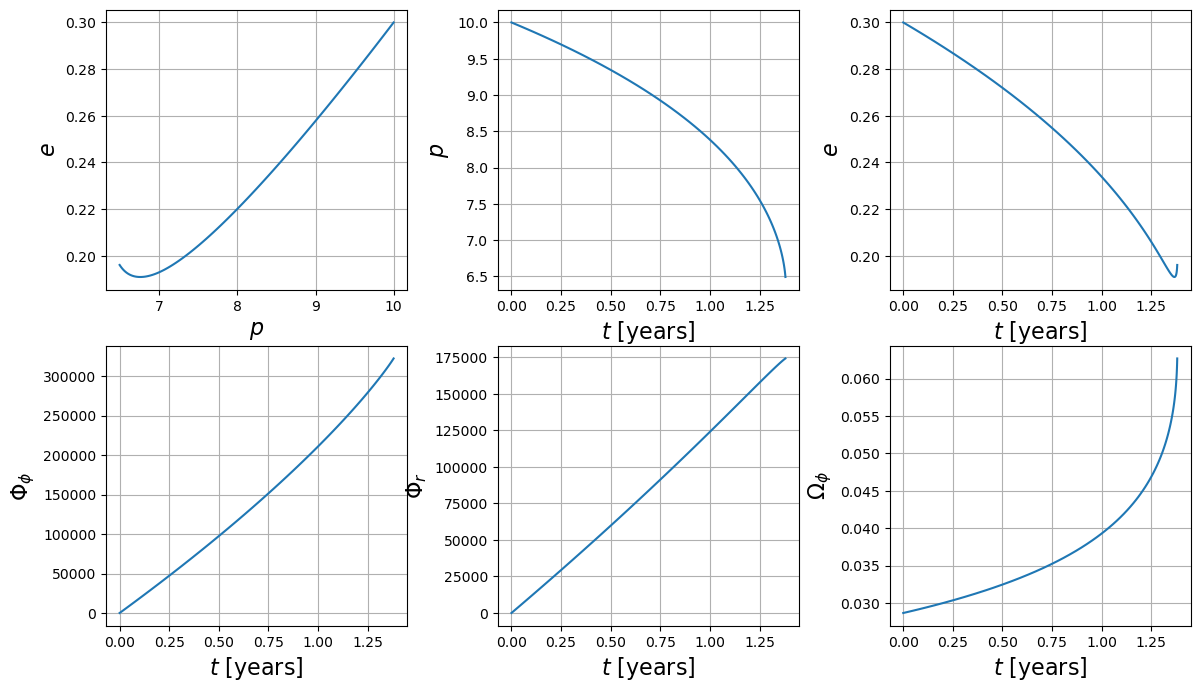

In [4]:
# set initial parameters for Schwarzschild orbit
M = 1e6   # Primary mass  (solar masses)
mu = 1e1  # Secondary mass  (solar masses)
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3  # range [0.0, 0.7]

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0

# additional information
kwargs = dict(dt=10.0, # initial time step,
              T=2.0, # Time duration in years
              err=1e-10 # integrator error -- used as a tolerance to solve coupled ODEs above
             )

# Compute trajectory of smaller body: p(t), e(t), xI(t), Phi_phi(t), Phi_theta(t), Phi_r(t)
t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)


# get dimensionless fundamental frequencies
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p, e, x)


# Plot the results
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_r$', r'$\Omega_\phi$']
xlabels = [r'$p$', r'$t$ [years]', r'$t$ [years]', r'$t$ [years]', r'$t$ [years]', r'$t$ [years]', r'$t$ [years]', r'$t$ [years]']
ys = [e, p, e, Phi_phi, Phi_r, OmegaPhi]
xs = [p, t/YRSID_SI, t/YRSID_SI, t/YRSID_SI, t/YRSID_SI, t/YRSID_SI]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    ax.grid()

## Exercise 0

1. For the default parameters $(M,\mu,a,p_{0},e_{0},(x_{I})_{0}) = (10^{6}, 10, 0, 10, 0.3, 1)$ with $T = 2$ years, verify that the final point in semi-latus rectum corresponds to the separatrix defined by $p = 6 + 2e$. Change the time of evolution $T$ and make a note of what you find.
2. Modify the mass-ratio of the system above by increasing/decreasing $M$ whilst keeping $\mu$ (and all other parameters) fixed. What do you observe about the orbital evolution in semi-latus rectum $p(t)$? You may need to increase the time of evolution $T$. You will find that $\dot{p} = dp/dt$ decreases as $M$ is increased.

In [ ]:
# EXERCISE 0!

# set initial parameters for Schwarzschild orbit
# M = 1e6   # Primary mass  (solar masses)
# mu = 1e1  # Secondary mass  (solar masses)
# p0 = 10.0 # range [separatrix, 45]
# e0 = 0.3  # range [0.0, 0.7]

# # run trajectory
# # must include for generic inputs, will fix a = 0 and x = 1.0
# a = 0.0
# x = 1.0

# # additional information
# kwargs = dict(dt=10.0, # initial time step,
#               T=2.0, # Time duration in years
#               err=1e-10 # integrator error -- used as a tolerance to solve coupled ODEs above
#              )

# # Compute trajectory of smaller body: p(t), e(t), xI(t), Phi_phi(t), Phi_theta(t), Phi_r(t)
# t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
#                                               Phi_phi0=0.0,
#                                               Phi_theta0=0.0,
#                                               Phi_r0=0.0,
#                                               **kwargs)

# p_sep = [INSERT YOUR CODE HERE]
# print("Separatrix is at ",p_sep)
# print("Final point in semi-latus rectum is", p[-1])

In [ ]:
# EXERCISE 0!

# set initial parameters for Schwarzschild orbit

mu = 1e1  # Secondary mass  (solar masses)
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3  # range [0.0, 0.7]

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0

# additional information
kwargs = dict(dt=10.0, # initial time step,
              T=1.0, # Time duration in years
              err=1e-10 # integrator error -- used as a tolerance to solve coupled ODEs above
             )

# Compute trajectory of smaller body: p(t), e(t), xI(t), Phi_phi(t), Phi_theta(t), Phi_r(t)

# M_vec = 10**np.arange(4,7,1)
# N_plots = len(M_vec)

# fig,ax = plt.subplots(1,N_plots, figsize = (12,4))
# i=0
# for M in M_vec:
#     t, p, e, xI, Phi_phi, Phi_theta, Phi_r = [INSERT YOUR CODE HERE]

#     ax[i].plot(t/60/60/24,p,label = "M = {}".format(M))
#     ax[i].set_xlabel(r'time [days]', fontsize = 18)
#     ax[i].set_ylabel(r'semi-latus rectum $p$',fontsize = 18)
#     ax[i].set_title(r'Primary mass = {} $M_\odot$'.format(M),fontsize = 14)
#     ax[i].legend()
#     ax[i].grid()


#     i+=1



### Quasi-Keplerian parameters: $(p,e)$
We want to remark that $p$ and $e$ are quasi-Keplerian parameters and gauge dependent quantities (they depend on the choice of coordinate system). They "converge" to the Newtonian equivalent parameters in the weak field regime (far away in radial coordinate $r$ from the black hole). Below we show a plot of ellipsis based on these parameters at diferent stages of the evolution. This is useful to get a sense of the evolution of the orbit but you should not interpret these ellipsis as real orbits!

In [ ]:
# set initial parameters for Schwarzschild orbit
M = 1e6   # Primary mass  (solar masses)
mu = 1e1  # Secondary mass  (solar masses)
p0 = 10.5 # range [separatrix, 45]
e0 = 0.3  # range [0.0, 0.7]

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0

# additional information
kwargs = dict(dt=10.0, # initial time step,
              T=2.0, # Time duration in years
              err=1e-10 # integrator error -- used as a tolerance to solve coupled ODEs above
             )

# Compute trajectory of smaller body: p(t), e(t), xI(t), Phi_phi(t), Phi_theta(t), Phi_r(t)
t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)

import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')

plt.figure(figsize=(8,8))
for ii in range(0,len(p),12):
    pp = p[ii]
    ee = e[ii]
    Csi = np.linspace(0.0,2*np.pi,100)
    rr = pp / (1 + ee * np.cos(Csi))
    xx = rr * np.cos(Csi)
    yy = rr * np.sin(Csi)
    plt.plot(xx,yy,c=cmap(ii/len(p)),label=f'time = {t[ii]/(YRSID_SI):.2e} years' )
plt.scatter(0,0,c='k',label='MBH')
plt.legend()
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.xlabel(r'$r\cos(\xi)$',fontsize = 16)
plt.ylabel(r'$r\sin(\xi)$', fontsize = 16)
plt.title('Illustrative depiction of orbits',fontsize = 25)
plt.show()

## Evolution of semi-latus rectum and eccentricity

The goal of the next cell is to understand how the semi-latus rectum and eccentricity evolve together. Notice that for trajectories with semi-latus rectum close to the separatrix, one observes an "uptick" in the eccentricity. This is a well known feature and is further discussed in this [article](https://arxiv.org/abs/gr-qc/0203086).

In [ ]:
# set initial parameters
M = 1e6     # Primary mass (solar masses)
mu = 1e1    # Secondary mass (solar masses)

# run trajectory

# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0

# additional information
kwargs = dict(dt=10.0, # initial time step,
              T=100.0, # Time duration in years [Excessive, but want to evolve to separatrix! here]
              err=1e-10 # integrator error
             )

p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

plt.figure()


# Here we plot the trajectory with all parameters fixed (e0 = 0.7) apart from p0
for p0 in np.linspace(7, 20, num=10):
    e0=0.7
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)
    plt.plot(p,e)

# Now we plot the trajectory with all parameters fixed (p0 = 20) apart from e0
for e0 in np.linspace(0, 0.69, num=10):
    p0=20.0
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)
    plt.plot(p,e)

# Separatrix given by p_sep = 6 + 2*e
pp = np.linspace(6,7.5,100)
ecc = (pp - 6)/2
plt.plot(pp,ecc,'k--',label='separatrix')
plt.xlabel('p')
plt.ylabel('e')
plt.legend()
plt.show()


### Trajectory duration as a function of mass ratio, eccentricity, semi-latus rectum

In Exercise 0 above we saw that the length of the trajectory, in time, is very sensitive to the mass-ratio of the system. The coupled ODEs

$$
\frac{d}{dt}p = \epsilon \, f^{(1)}_p(a, p, e, x_I) + \mathcal{O}(\epsilon^2)
$$
$$
\frac{d}{dt}e = \epsilon \, f^{(1)}_e(a, p, e, x_I) + \mathcal{O}(\epsilon^2)
$$

show that $\dot{p} \sim \dot{e} \sim \epsilon$. It should then be expected that the rate of change of the orbital parameters $p(t)$ and $e(t)$ is directly proportional to the size of the mass-ratio of the system. We will investigate this below.


In [ ]:
# set initial parameters
M = 1e6   # Primary mass
mu = 1e1  # Secondary mass
p0 = 12 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# run trajectory

# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0


# Fix time duration to a very large number (1000 years) so that we obtain the time duration from trajectory

kwargs = dict(dt=10.0, # initial time setp,
              T=1000.0,
              err=1e-10 # integrator error
             )

mass_ratio_vector = 10**np.linspace(-4.0, -7.0, num=10)

tfinal = []
for count,epsilon in enumerate(mass_ratio_vector):

    # get secondary mass for fixed mass ratio
    mu = M * epsilon
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                                  Phi_phi0=0.0,
                                                  Phi_theta0=0.0,
                                                  Phi_r0=0.0,
                                                  **kwargs)

    # inspiral duration (divide by YRSID_SI to get it in years)
    tfinal.append(t[-1]/YRSID_SI)
    if count%3 == 0:
        print("For a mass-ratio of epsilon = {}, time duration is T = {} years".format(epsilon,t[-1]/YRSID_SI))


In [ ]:
plt.figure()
plt.loglog(mass_ratio_vector, tfinal,'*', ms = "16", c = 'red')
plt.ylabel('Time duration [years]',fontsize = 16)
plt.xlabel('Mass ratio',fontsize = 16)
plt.title("")
plt.grid()
plt.show()

### Discussion of plot above

In each trajectory calculation, the initial semi-latus rectum is fixed. The only quantity that is changing is the mass ratio $\epsilon = \mu/M$. As $\epsilon$ decreases, the trajectory evolution time increases. The time of evolut ion is thus inversely proportional to the mass-ratio of the system. We thus see that

$$
T_{\text{observation}} \sim 1/\epsilon
$$

Notice that for $\epsilon = 10^{-7}$, with the parameters given above, it would have taken 396 years to plunge. Whereas with a mass-ratio of $\epsilon = 10^{-4}$, it would have only taken 144 days.  

Cool.

## Exercise 1

Let us now understand how the inspiral duration changes for different initial eccentricity or different initial semi-latus rectum. Remember the range of validity of the parameters and produce two plots:
1. Time duration vs initial eccentricity (fixing all the other parameters)
2. Time duration vs initial semi-latus rectum (fixing all the other parameters)

If you have time, produce also this plot:

3. Time duration vs M/epsilon (M=Mass MBHS and epsilon=Mass ratio). Prove that, for different total masses and mass ratios, the behavior of Time duration vs M/epsilon is always the same (Hint: use two for loops, one for $M$ and the other for $\epsilon$).

You should find that:

1. The relation between time-duration and eccentricity is weak.
2. The relation between time-duration and semi-latus rectum is exponential.
3. The relation between time-duration and $M/\epsilon$ is perfectly linear.

In [5]:
# Time duration vs initial eccentricity -- It's your turn!

## # set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0


# Fix time duration to a very large number (100 years) so that we obtain the time duration from trajectory
kwargs = dict(dt=10.0, # initial time setp,
              T=1000.0,
              err=1e-10 # integrator error
             )

# ecc = np.linspace(0.01, 0.7, num=10)

# tfinal = []
# for e0 in ecc:

#  [INPUT YOUR CODE IN HERE]

#     tfinal.append(t[-1]/YRSID_SI)


# plt.figure()
# plt.plot(ecc, tfinal)
# plt.ylabel('Time duration [years]')
# plt.xlabel('e0')
# plt.show()



In [ ]:
# Time duration vs initial semi-latus rectum

## # set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0


# Fix time duration to a very large number (100 years) so that we obtain the time duration from trajectory
kwargs = dict(dt=10.0, # initial time setp,
              T=1000.0,
              err=1e-10 # integrator error
             )

# tfinal = []
# e0 = 0.0 # reset eccentricity
# pp = np.linspace(7.0, 30.0, num=10)
# for p0 in pp:

#  [INPUT YOUR CODE IN HERE]

#     tfinal.append(t[-1]/YRSID_SI)


# plt.figure()
# plt.loglog(pp, tfinal)
# plt.ylabel('Time duration [years]')
# plt.xlabel('p0')
# plt.show()





In [ ]:

## # set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0


# Fix time duration to a very large number (100 years) so that we obtain the time duration from trajectory
kwargs = dict(dt=10.0, # initial time setp,
              T=1000.0,
              err=1e-10 # integrator error
             )

# tfinal = []
# e0 = 0.2 # reset
# p0=10.0

# epsilon_vector = 10**np.linspace(-4.0, -6.0, num=10)
# Mvec = 10**np.linspace(4.0, 7.0, num=10)

# plt.figure()
# for M in [CODE HERE]:
#     tfinal = []
#     for epsilon in [CODE HERE]:

#         # get secondary mass for fixed mass ratio

#         mu = [CODE HERE]
#         CODE HERE -- Generate your trajectory for given choices of M and epsilon.

#         # inspiral duration (divide by YRSID_SI to get it in years)
#         tfinal.append(t[-1]/YRSID_SI)

    # plt.plot(M/epsilon_vector, tfinal)
# plt.ylabel('Time duration [years]')
# plt.xlabel('$M/\epsilon$')
# plt.show()

### Number of cycles and differences between trajectories
It is often common to introduce the number of cycles $\mathcal{N}_\varphi (t)= \Phi_\varphi(t)/(2\pi)$ to quantify the number of times the compact object orbits around the MBH. This is useful to quantify the difference between trajectories.

In [ ]:
# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# set initial parameters
M1 = 1e6
mu1 = 1e1

t1, p1, e1, xI1, Phi_phi1, Phi_theta1, Phi_r1 = traj(M1, mu1, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)

M2 = 5e5
mu2 = 5
t2, p2, e2, xI2, Phi_phi2, Phi_theta2, Phi_r2 = traj(M2, mu2, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)

plt.figure()
plt.plot(t1/YRSID_SI,Phi_phi1/(2*np.pi), label=f'mu={mu1}, M={M1/1e6} x $10^6$, $\epsilon$ = {mu1/M1}')
plt.plot(t2/YRSID_SI,Phi_phi2/(2*np.pi), label=f'mu={mu2}, M={M2/1e6} x $10^6$, $\epsilon$ = {mu2/M2}')
plt.ylabel('Number of cycles')
plt.xlabel('t [years]')
plt.legend()
plt.grid()
plt.show()

print("Final number of cycles of system 1 with mu = {} and M = {} is N_cyles = {}".format(mu1,M1,Phi_phi1[-1]/(2*np.pi)))
print("Final number of cycles of system 2 with mu = {} and M = {} is N_cycles = {}".format(mu2,M2,Phi_phi2[-1]/(2*np.pi)))

The two systems have the same mass ratio and the same final number of cycles. However, the number of cycles accumulated per second is different. An EMRI system with larger MBH "more slowly" than a system with smaller `M`.  Notice that the frequencies are related to the time derivative of the number of cycles

$$
\frac{d}{dt} \mathcal{N}_\varphi = \frac{1}{2 \pi}\frac{d}{dt} \Phi_\varphi = \frac{1}{2 \pi} \Omega_\varphi\, .
$$

In [ ]:
# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# set initial parameters
M1 = 1e6
mu1 = 1e1

epsilon = mu/M



t1, p1, e1, xI1, Phi_phi1, Phi_theta1, Phi_r1 = traj(M1, mu1, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)

OmegaPhi1, OmegaTheta1, OmegaR1 = get_fundamental_frequencies(a, p1, e1, xI1)

M2 = 5e5
mu2 = 5
t2, p2, e2, xI2, Phi_phi2, Phi_theta2, Phi_r2 = traj(M2, mu2, a, p0, e0, xI1,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)

OmegaPhi2, OmegaTheta2, OmegaR2 = get_fundamental_frequencies(a, p2, e2, xI2)

plt.figure()
plt.plot(t1/YRSID_SI,OmegaPhi1/(2*np.pi), label=f'mu={mu1}, M={M1/1e6} x $10^6$, $\epsilon$ = {mu1/M1}')
plt.plot(t2/YRSID_SI,OmegaPhi2/(2*np.pi), label=f'mu={mu2}, M={M2/1e6} x $10^6$, $\epsilon$ = {mu2/M2}')
plt.ylabel(r'$dN_{\phi}/dt$',fontsize = 20)
plt.xlabel('t [seconds]')
plt.legend()
plt.grid()
plt.show()


## Exercise 2
Plot the FINAL number of cycles (`Ncycle.append(Phi_phi[-1]/(2*np.pi))`) for different mass ratios. What do you find?

In [ ]:
# # set initial parameters
M = 1e6
mu = 1e1

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# Ncycle = []
# for epsilon in epsilon_vector:

#     # get secondary mass for fixed mass ratio
#     mu = [CODE HERE]
#     t, p, e, xI, Phi_phi, Phi_theta, Phi_r = [CODE HERE]

#     Ncycle.append([CODE HERE])


# plt.figure()
# plt.loglog(mass_ratio_vector, Ncycle)
# plt.ylabel('Number of cycles')
# plt.xlabel('Mass ratio')
# plt.show()

### Fundamental frequencies and harmonics

Over short time-scales, an EMRI Waveform can thought as a Fourier series where the frequencies $\omega_{mnk}$ are given by

$$
\omega_{mnk} = m \Omega_\varphi + n \Omega_r + k \Omega_\theta
$$

Therefore is possible to plot the frequency evolution of each harmonic given a trajectory. This can be useful to understand which frequency range each harmonic spans.

In [ ]:
# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# set initial parameters
M = 1e6
mu = 1e1

t1, p1, e1, xI1, Phi_phi1, Phi_theta1, Phi_r1 = traj(M, mu, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)
# get the fundamental frequencies
OmegaPhi1, OmegaTheta1, OmegaR1 = get_fundamental_frequencies(a, p1, e1, xI1)

M2 = 5e5
mu2 = 5
t2, p2, e2, xI2, Phi_phi2, Phi_theta2, Phi_r2 = traj(M2, mu2, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)
OmegaPhi2, OmegaTheta2, OmegaR2 = get_fundamental_frequencies(a, p2, e2, xI2)

plt.figure()
# we need to divide by the total Mass and convert to seconds
plt.plot(t1,OmegaPhi / (M1 * MTSUN_SI) , label=f'mu={mu1}, M={M1/1e6} x $10^6$')
plt.plot(t2,OmegaPhi2/ (M2 * MTSUN_SI), label=f'mu={mu2}, M={M2/1e6} x $10^6$')
plt.ylabel(r'$\Omega_\varphi$ [1/s]')
plt.xlabel('t [s]')
plt.legend()
plt.grid()
plt.show()

The system with smaller MBH mass spans more frequencies and evolves more quickly than the system with larger MBH mass. This piece of code will be exceptionally useful for a later exercise. Understand here that, for the $\phi$ angular frequency $\Omega_{\phi}$, we can determine up to what mode in $m$ we are sensitive to when analysing EMRI waveforms.

# Schwarzchild Waveforms in the source frame

So far in this tutorial we have focused on how to generate the trajectory of the smaller body around a massive black hole given an initial set of input parameters. Now, given a set of input parameters that determine a trajectory, we will focus on how to generate the final source frame Schwarzschild waveform. The rest of this tutorial will focus on time domain, frequency domain and time-frequency domain representations of EMRI waveforms. There will also be a few extra, more data analysis focused exercises as one progresses through the tutorial.

We begin with the time-domain representation of an EMRI waveform.


## Time Domain Representation of Waveforms


At large luminosity distances from the source, the source-frame EMRI waveform is given by

$$
    h_{+} - ih_{\times} = \frac{\mu}{d_L}\sum_{lmn} A_{lmn}(p(t),e(t),x_{I}(t)) \, S_{lmn}(\theta,\phi) \, \exp(-i\Phi_{mn}(t)).
$$

*Note:* We will not give a detailed tutorial on the pieces that determine the harmonic content of the amplitudes $A_{lmn}$ or the spin weighted spherical harmonics $S_{lmn}$. That's outside the scope of this work though, if people are curious, feel free to talk to me.

## GPU acceleration

From a data analysis perspective, we require EMRI waveforms that can be generated in around one second. This is due to the immense number of waveform generations required for parameter estimation algorithms, which is likely only a fraction of the amount required for the actual search phase! The speed of EMRI waveforms depend on two crucial ingredients. One is how quickly the trajectory can be built and the other is how quickly the individual harmonics (pairs of modes eg. (l,m,n) = (2,2,0) ) can all be summed. For orbits with significant eccentricities, the numbers of harmonics can be huge (in the thousands)!

The trajectories are quickly computed by integrating on a sparse grid that becomes more fine as the separatrix is approached. The waveforms are quickly generated by exploting GPUs to parallelise the sum over $(l,m,n)$. Compared to single CPUs, speed ups of order $\sim 2500$ are observed when compared to a single GPU. In this tutorial, using google collab, we will use google collabs basic GPU version.

![image.png](https://github.com/OllieBurke/EMRI_Workshop/blob/main/docs/images/gpu.jpg?raw=true)

The next few cells will focus on generating the EMRI waveform in the time domain.

In [ ]:
# We first define a few key word arguments to help our EMRI generator understand precisely what we want.

# GPU accelerated waveforms, this is an absolute game changer.
try:
    import cupy as cp
    use_gpu = True
    xp = cp
except ImportError:
    use_gpu = False
    xp = np



few_gen = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

# parameters
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

wave = few_gen(M, mu, p0, e0, theta, phi,Phi_phi0=0.0,  dt=dt, T=0.01)  #  assumes dt = 10.0 for max T = 0.01 year

plt.figure()
if use_gpu:
    plt.plot(xp.asnumpy(wave.real[:400]))
    plt.plot(xp.asnumpy(wave.imag[:400]))
else:
    plt.plot(wave.real[:400])
    plt.plot(wave.imag[:400])
plt.show()

## EMRI Waveforms in different domains
The output of FEW is a time domain waveform, i.e. the dimensionless strain as a function of time. Later on in this tutorial we will discuss a frequency domain model. We are currently working on trying to output an EMRI waveform directly in the time-frequency domain... watch this space!

Let's have a look at the waveform at different stages of the trajectory.

In [ ]:
# parameters
M = 1e6
mu = 1e1
p0 = 10.63
e0 = 0.3
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0
# notice that we are providing the distance parameter
wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=2.0)  #  assumes dt = 10.0 for max T = 1.0 year
time = np.arange(0, len(wave))*dt

# On my local machine, this took me five minutes to execute. I hope you have a GPU enabled!

## The full signal

In [ ]:
plt.figure(figsize=(16,10))
if use_gpu:
    plt.plot(time/YRSID_SI, xp.asnumpy(wave.real))
else:
    plt.plot(time/YRSID_SI, wave.real)
plt.ylabel(r'$h_+$', fontsize = 16)
plt.xlabel('t [years]', fontsize = 16)
plt.show()

What we can now do is check to see how the waveform evolves in time. Given our recently built intuition from the trajectory part of the tutorial, we should expect to see the rate of change of frequency evolve with time. We will now compare snapshots of the waveform as the smaller body gets closer to the separatrix.

In [ ]:
t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)

j0 = 0
j1 = 3000000
j2 = 6000000
j3 = -400

t_index_j1 = np.argwhere(t > time[j1])[0][0]
t_index_j2 = np.argwhere(t > time[j2])[0][0]
t_index_j3 = np.argwhere(t > time[j3])[0][0]

print(t_index_j3)

if use_gpu:
    wave_np = xp.asnumpy(wave.real)
else:
    wave_np = wave.real

In [ ]:
fig, ax = plt.subplots(4,2, figsize = (14,16))

ax[0][0].set_title("Location of small body", fontsize = 16)
ax[0][0].plot(t/YRSID_SI, p)
ax[0][0].plot(t[0]/YRSID_SI,p[0], 'ro', ms = 12, label = 'Small body')
ax[0][1].plot(time[0:400]/60, wave_np[0:400])

ax[0][1].set_title("Waveform", fontsize = 16)
ax[1][0].plot(t/YRSID_SI, p)
ax[1][0].plot(t[t_index_j1]/YRSID_SI,p[t_index_j1], 'ro', ms = 12)
ax[1][1].plot(time[j1:j1 + 400]/YRSID_SI, wave_np[j1:j1 + 400])

ax[2][0].plot(t, p)
ax[2][0].plot(t[t_index_j2],p[t_index_j2], 'ro', ms = 12)
ax[2][1].plot(time[j2:j2 + 400]/YRSID_SI, wave_np[j2:j2 + 400])

ax[3][0].plot(t/YRSID_SI, p)
ax[3][0].plot(t[t_index_j3]/YRSID_SI,p[t_index_j3], 'ro', ms = 12)
ax[3][1].plot(time[j3:]/YRSID_SI, wave_np[j3:])


for i in range(4):
    for j in range(4):
        ax[j][0].set_xlabel(r't [years]', fontsize = 16)
        ax[j][0].set_ylabel(r'$p(t)$', fontsize = 16)
        ax[0][0].legend(fontsize = 16)
        ax[j][1].set_ylabel(r'$h_+$', fontsize = 16)
        ax[j][1].set_xlabel(r't [years]',fontsize = 16)
        if j == 0:
            ax[0][1].set_xlabel('t [minutes]', fontsize = 16)
        # ax[0][j].set_xlabel('t [years]', fontsize = 16)
    plt.show()

Notice that as the smaller body ventures closer to the separatrix, both the amplitude and frequencies become larger and larger.

# Optional Exercise

Repeat the same plot as above but instead of plotting the evolution of semi-latus rectum, plot the angular frequency $\Omega_{\phi}$.

## Fourier Domain, Signal to noise ratio and Overlaps.

Within gravitational wave astronomy, data analysis is usually conducted in the frequency domain. This is for a multitude of reasons, one being that our probabilistic models used for inferring parameters (such as the likelihood) dramatically simplifies in comparison to its time-domain counterpart. Similarly, analysing gravitational waveforms as a function of frequency may simply reveal more information about the underlying structure of the signal. In this section, we will define the power spectral density of the noise $S_{n}(f)$, a function that qualitatively describes the root mean square average of noise fluctuations from some stationary process. We will then analyse the EMRI waveform in the frequency domain and compute a few useful statistics used within gravitaitonal wave astronomy.

In [ ]:
# load Power Spectral Density of LISA. This represents how loud the instrumental noise is.
def PowerSpectralDensity(f):
    """
    PSD obtained from: https://arxiv.org/pdf/1803.01944.pdf

    Removed galactic confusion noise.
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = 19.09*10**-3

    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise

    PSD = ((10/(3*L**2))*(Poms + (4*Pacc)/((2*np.pi*f))**4)*(1 + 0.6*(f/f0)**2)) # PSD

    return PSD

In [ ]:
# we take the Fast Fourier transform of the signal
hp_fft = xp.fft.rfft(wave.real)*dt
hx_fft = -xp.fft.rfft(wave.imag)*dt

freq = np.fft.rfftfreq(len(wave),dt)
freq[0] = freq[1]
PSD_np = PowerSpectralDensity(freq)
if use_gpu:
    PSD_cp = xp.asarray(PSD_np)

plt.figure()
if use_gpu:
    plt.loglog(freq, xp.asnumpy(xp.abs(hp_fft)**2), label = 'Frequency domain EMRI')
else:
    plt.loglog(freq, np.abs(hp_fft)**2, label = 'Frequency domain EMRI')
plt.plot(freq, PSD_np,label='Approx LISA Sensitivity curve',c = 'black', ls = 'dashed')
plt.legend()
plt.xlim([1e-5,1e-1])
plt.ylim([1e-44,1e-29])
plt.ylabel(r'$|\tilde{h}(f)|^2$')
plt.xlabel('f [Hz]')
plt.show()

We define the inner product:
$$
(a (t)|b (t)) =4 \Re \int _{0} ^\infty \frac{\tilde{a} ^* (f) \tilde{b} (f) }{S_n (f)} \, {\rm d} f \, .
$$
where the tilde indicates the Fourier transform, the symbol $^*$ indicates the complex conjugation, and $S_n (f)$ is the one-sided noise power spectral density, which can be interpreted as the size of the root mean square fluctuations at a given frequency $\Delta n _{\text{rms}} \sim \sqrt{S_n(f) \Delta f}$. From a practical point of view the spectral density represents our information on the detector sensitivity and the aforementioned inner product can be used to quantify the Signal to Noise Ratio (SNR) of a waveform $h(t)$:

$$
{\rm SNR}^2 =(h (t)|h (t)) =4 \Re \int _{0} ^\infty \frac{|\tilde{h} (f)| }{S_n (f)} \, {\rm d} f \approx 4 \Re \sum_{i=0}^{N/2 - 1}\frac{|\tilde{h}(f_{i})|^2}{S_{n}(f_{i})}\Delta f\, .
$$

for $\Delta f$ the spacing between frequencies defined by $\Delta f = 1/N\Delta t = 1/T_{\text{observation}}$.
EMRIs are usually considered to be detectable for $SNR\gtrsim 15$ or so  

In [ ]:
def inner_product(a,b,dt):
    a_tilde = xp.fft.rfft(a)*dt
    b_tilde = xp.fft.rfft(b)*dt
    freq = xp.fft.rfftfreq(len(a),dt)
    freq[0] = freq[1]
    df = freq[2]-freq[1]
    psd_f = xp.asarray(PowerSpectralDensity(freq))
    inn_prod_cp = 4.0 * xp.real ( xp.sum( xp.conj(a_tilde) * b_tilde * df / psd_f) )
    inn_prod_np = xp.asnumpy(inn_prod_cp)
    return inn_prod_np

# the SNR of the previous waveform is
SNR = np.sqrt(inner_product(wave.real,wave.real,dt))
print("SNR =",SNR)

### Exercise 3
Verify that the SNR of an EMRI waveform is:
- inversely proportional to the distance
- directly proportional to the secondary mass `mu` for fixed total Mass and duration. Make sure that the source does not plunge before the times provided. Otherwise, you might not get the direct proportionality, i.e. set T=`0.001` and vary $\mu\in[10,100]$.


In [ ]:
# your turn

M = 1e6
mu = 1e1
p0 = 10.63
e0 = 0.3
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame


dt = 10.0

# plt.figure()
# for dd in np.linspace(1.0,5.0,num=10):
#     wave = few_gen(M, mu, p0, e0, theta, phi, dist=dd, dt=dt, T=2.0)
#     SNR = [INSERT YOUR CODE HERE ]
#     plt.plot([INSERT YOUR CODE HERE])

# plt.xlabel('1/d')
# plt.ylabel('SNR')
# plt.show()


# plt.figure()
# for mu in np.linspace(1.0,100.0,num=10):
#     wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=0.1)
#     SNR = [INSERT YOUR CODE HERE]
#     plt.plot([INSERT YOUR CODE HERE])
# plt.xlabel('mu')
# plt.ylabel('SNR')
# plt.show()

We will now introduce another quantity which will be useful for estimating qualitatively how different two waveforms $a(t)$ and $b(t)$ are. We define the ehe Overlap $\mathcal{O}(a,b)$ between two waveform models $a$ and $b$ by:
$$
\mathcal{O} (a,b) = \frac{<{a}|{b}>}{\sqrt{<{a}|{a}>} \sqrt{<{b}|{b}>}} \in [-1,1] \, .
$$
The overlap expresses how similar two signals $a$ and $b$ by weighting the product with the power spectral density of the detector $S_n (f)$. If two signals are identical then the overlap is 1. Another quantity often used in gravitational wave data analysis is the mismatch which is defined as 1 minus the overlap.

In [ ]:
def overlap(a,b,dt):
    a_b = inner_product(a,b,dt)
    a_a = inner_product(a,a,dt)
    b_b = inner_product(b,b,dt)
    return a_b / np.sqrt(a_a * b_b)

print("overlap of a signal with itself = ",overlap(wave.real,wave.real,dt))

In [ ]:
# parameters
M = 1e6
mu = 1e1
p0 = 10.63
e0 = 0.3
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

base_sig = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=1)
t_base = np.arange(0,len(base_sig)*dt,dt)

In [ ]:
cmap = matplotlib.cm.get_cmap('inferno')
fig, axs = plt.subplots(2, 1)
axs[0].plot(t_base[:100],xp.asnumpy(base_sig.real[:100]))
axs[1].scatter(0.0, 1)
axs[1].set_xlabel('phase')
axs[1].set_ylabel('Overlap')
axs[0].set_ylabel('$h_+$')
for phase in np.linspace(0.1, 2*np.pi,num=6):
    wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=1) * xp.exp(1j*phase)
    t_wave = np.arange(0,len(wave)*dt,dt)
    O = overlap(base_sig.real,wave.real,dt)
    axs[0].plot(t_wave[0:100],xp.asnumpy(wave.real[0:100]),'--', color= cmap(phase/(xp.pi*2)))
    axs[0].set_xlabel(r'time [seconds]')
    axs[1].scatter(phase, O, color= cmap(phase/(np.pi*2)))

plt.tight_layout()

In [ ]:
# parameters
M = 1e6
mu = 1e1
p0 = 10.63
e0 = 0.3
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

cmap = matplotlib.cm.get_cmap('inferno')
fig, axs = plt.subplots(1, 1)
axs.set_xlabel('$log_{10}\delta e$')
axs.set_ylabel('Overlap')
vec = 10**np.linspace(-7, -2,num=10)  # Here we will add small perturbations to parameters
logd = np.log10(vec)

for T in [0.1, 1, 2]:
    base_sig = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=T)
    O=[]
    for delta in vec:
        wave = few_gen(M, mu, p0, e0*(1+delta), theta, phi, dist=1.0, dt=dt, T=T)
        O.append(overlap(base_sig.real,wave.real,dt))

    axs.scatter(logd, (O) , label=f'T={T}')

plt.legend()
plt.show()

### Exercise 4
Repeat the previous plot by varying each of the EMRI parameters. Which parameter makes the overlap drop faster?

In [ ]:
# # your turn

# parameters
# M = 1e6
# mu = 1e1
# p0 = 10.63
# e0 = 0.3
# theta = np.pi/3  # polar viewing angle in source frame
# phi = np.pi/4  # azimuthal viewing angle in source frame
# dt = 10.0

# cmap = matplotlib.cm.get_cmap('inferno')
# fig, axs = plt.subplots(1, 1)
# axs.set_xlabel('$\log_{10}\delta e$')
# axs.set_ylabel('Overlap')
# vec = 10**np.linspace(-6, -2,num=10)
# logd = np.log10(vec)

# T=2

# base_sig = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=T)

# Focus on Parameter M

# O=[]
# for delta in vec:
#     wave = few_gen([INSERT CODE HERE], mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=T)
#     O.append(overlap(base_sig.real,wave.real,dt))

# axs.scatter(logd, O , label=f'M')

# Focus on Parameter mu

# O=[]
# for delta in vec:
#     wave = few_gen(M, [INSERT CODE HERE], p0, e0, theta, phi, dist=1.0, dt=dt, T=T)
#     O.append(overlap(base_sig.real,wave.real,dt))

# axs.scatter(logd, O , label=f'mu')

# Focus on Parameter M

# O=[]
# for delta in vec:
#     wave = few_gen(M, mu, [INSERT CODE HERE], e0, theta, phi, dist=1.0, dt=dt, T=T)
#     O.append(overlap(base_sig.real,wave.real,dt))

# axs.scatter(logd, O , label=f'p0')


# plt.legend()
# plt.show()


## Reflection

Let's take a little bit of time to understand exactly what has happened in the plot above. What we are doing here is comparing the "similarity" between one base waveform and another waveform with identical parameter sets apart from the eccentricity. What we see here is that if we are to perturb the eccentricity, say, by a very small amount $\gtrsim 10^{-6}$, only then do we start to see a significant change in the waveform. Loosely speaking, this implies that the EMRI waveforms are immensely sensitive to small perturbations in their parameters.

# Precision of EMRI Parameters

## The Likelihood Function

As we saw in the previous exercise, the waveforms emitted from EMRI signals are immensely sensitive to perturbations in their parameters. If we were to detect and recover the parameters of an EMRI, we would find that our ability to measure their parameters would be unparalleled by any other gravitational wave source. We now wish to make this statement a little bit more concrete.

For a known form of the PSD, we define the likelihood function

$$
\log p(d|\boldsymbol{\theta}) \approx - \frac{1}{2}(h_{e} - h(\boldsymbol{\theta}) | h_{e} - h(\boldsymbol{\theta}))
$$

for $h_{e}$ the exact waveform model and $h(\boldsymbol{\theta})$ some model template we wish to use to infer the parameters of the true waveform model. The dimension of the full EMRI parameter space is $\sim 14$ dimensions and stochastic algorithms are normally used to estimate these parameters. We do not have time for this here, so instead we will show how sensitive the likelihood function is to a single parameter, let's say the eccentricity $e$.

In the cell below, we will plot the log-likelihood.

In [ ]:
# parameters
M = 1e6
mu = 1e1
p0 = 10.63
e0 = 0.3
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

true_wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=2.0)  # Generate true waveform

# plot likelihood
spacing = 4.6e-8

e_range = np.linspace(e0 - 3.5*spacing, e0 + 3.5*spacing, 30)  # Construct range of eccentricity
e_range[0] = e0  # Make sure that e0 is contained. Log-likelihood should be zero at this point.
e_range.sort()

llike_vec = []
for ecc_val in tqdm(e_range):
  wave_iteration = few_gen(M, mu, p0, ecc_val, theta, phi, dist=1.0, dt=dt, T=2.0)  #
  diff = true_wave - wave_iteration # See likelihood equation above.

  llike = -0.5*(inner_product(diff,diff,dt))  # Compute likelihood value
  llike_vec.append(llike)

# Plot results
plt.plot(xp.asnumpy(e_range),np.exp(xp.asnumpy(llike_vec)),'*')
plt.plot(xp.asnumpy(e_range),np.exp(xp.asnumpy(llike_vec)),c = 'black')
plt.xlabel(r'Eccentricity',fontsize = 16)
plt.ylabel(r'Likelihood',fontsize = 16)
plt.title(r'Plot of likelihood over 1 parameter', fontsize = 14)

# Reflection

If you look at the x axes, you will see that the likelihood is Gaussian in nature and is peaked at the true value $e_{0} = 0.3$. Due to how incredibly sensitive the EMRI waveform is to the initial eccentricity, we see that the likelihood quickly tapers off  and then very quickly tapers towards zero.

## Cheap way to estimate precision in parameters: Fisher Matrix

Instead of plotting the likelihood, there is a very cheap way to estimate our ability to measure parameters of EMRIs. One can compute the Fisher information matrix

$$
\Gamma_{ij} = (\partial_{i}h | \partial_{j}h) = 4\mathbb{R}\int_{0}^{\infty}\frac{1}{S_{n}(f)}\bigg\rvert \frac{\partial \tilde{h}}{\partial \theta^{i}} \frac{\partial \tilde{h}^{\star}}{\partial \theta^{j}}\bigg\rvert^{2} df
$$

The diagonal elements of the inverse Fisher matrix gives a guide on how well one can measure the parameters of the system. We give an example of how a Fisher matrix and estimate for the $1\sigma$ precision of the eccentricity below.


In [ ]:
de = 1e-7  # Set step size for numerical derivative

wave_p = few_gen(M, mu, p0, e0 + de, theta, phi, dist=1.0, dt=dt, T=2)
wave_m = few_gen(M, mu, p0, e0 - de, theta, phi, dist=1.0, dt=dt, T=2)
deriv_wave = ((wave_p - wave_m) / (2*de)) # Compute Derivative

deriv_wave_fft = xp.fft.rfft(deriv_wave)

gamma_ee = inner_product(deriv_wave.real,deriv_wave.real,dt)  # Just a scalar

precision_e = gamma_ee**(-1/2) # Reciprocal and square root.

# precision_e above is our approximate for the 1\sigma width of the likelihood
# function.



In [ ]:
# Let's check our result!
precision_e_np = xp.asnumpy(precision_e)

approx_pdf = np.exp(-(e_range - e0)**2 / (2*precision_e_np**2))

plt.plot(xp.asnumpy(e_range),np.exp(xp.asnumpy(llike_vec)),'*', label = 'Likelihood')
plt.plot(xp.asnumpy(e_range),xp.asnumpy(approx_pdf), label = 'FM approx')
plt.legend()

### Nailed it

As one can see from the plot above, we have managed to cheaply compute how well we expect to measure the EMRI parameters. This is very useful, it can take days, if not weeks to run full Bayesian inference on EMRIs. Hence, to scope out the LISA science of EMRIs, Fisher matrices can be used to cheaply understand how well one can measure parameters of various astrophysical scenarios.

# Exercise 5

Using the Fisher matrix formalism, try to understand how well we can measure the primary mass $M$ for the EMRI given above. If you get bored, try and investigate the other parameters as well.

Using the Fisher matrix, prove that the fisher information on the distance can be written as

$$
\Gamma_{d_{L}d_{L}} = \frac{\rho^{2}}{d_{L}^{2}}
$$

where $\rho^{2} = (h|h)$ is the optimal matched-filtering SNR. Then verify that, indeed, we can measure $\Delta d_{L} = d_{L}/\rho.$




In [ ]:
# dM = 1e-1  # Set step size for numerical derivative

# wave_p = few_gen([INSERT CODE HERE])
# wave_m = few_gen([INSERT CODE HERE])

# deriv_wave = [INSERT CODE HERE]

# deriv_wave_fft = xp.fft.rfft(deriv_wave)

# gamma_MM = inner_product(deriv_wave.real,deriv_wave.real,dt)  # Just a scalar

# precision_M = [INSERT CODE HERE]

# print("Precision we can expect to measure the primary mass is", precision_M)

# Analytical solution present at the bottom of this notebook ;)

## Time-Frequency Domain

So far we have analysed EMRIs in a specific domain: the time-domain. This is just one type of window in which to view the world of EMRIs. It may be more instructive to analyse EMRIs in other types of domains, such as the time-frequency or purely the frequency domain. In the cells that follow, we will plot a spectrogram of EMRIs to truly show the rich harmonic structure offered by this awesome sources.

In [ ]:
# parameters
M = 1e6
mu = 1e1
p0 = 9.55
e0 = 0.3
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=1.0)  # Generate our source
wave_np = xp.asnumpy(wave.real)

In [ ]:
from scipy import signal
# short fourier transform of the signal
f, t, Zxx = signal.stft(wave_np, 1/dt, nperseg=5000)

In [ ]:
plt.figure(figsize=(16,10))
cb = plt.pcolormesh(t/YRSID_SI, f, np.log10(np.abs(Zxx)), shading='gouraud')
plt.colorbar(cb,)
plt.title('STFT Magnitude',fontsize = 20)
plt.ylabel('Frequency [Hz]', fontsize = 20)
plt.xlabel('Time [Years]', fontsize = 20)
plt.yscale('log')
plt.ylim([1e-4, f[-1]])
plt.show()

### Exercise 6
In the previous plot the different harmonics of the waveform can be recognized as tracks in time-frequency space. As exercise, try to plot the frequency tracks as a function of time on top of the previous plot. Take the same input parameters and run a trajectory to obtain the `p` and `e` evolution. Then pass these arrays into the the function `get_fundamental_frequencies` and obtain the three fundamental frequencies. Then convert to the correct units and plot the frequency $f=(m \Omega_\varphi + n \Omega_r)/(2\pi)$ for some values of your choice for $m$ and $n$. See if you can identify some tracks yourself.

In [ ]:
# parameters
M = 1e6
mu = 1e1
p0 = 9.55
e0 = 0.3
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=1.0)
wave_np = xp.asnumpy(wave.real)

f, t, Zxx = signal.stft(wave_np, 1/dt, nperseg=5000)

time, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0, T=1.0, dt=dt)
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(0.0, p, e, 1.0)



In [ ]:
fharmonics_phi = [m*OmegaPhi / (M*MTSUN_SI) / (np.pi*2) for m in range(1,10)]
# fharmonics_r = [n*OmegaR / (M*MTSUN_SI) / (np.pi*2) for n in range(1,10)]

m = 1
n = 0

f_combo_r_phi = (m*OmegaPhi + n*OmegaR)/(M*MTSUN_SI)/(np.pi*2)
plt.figure(figsize=(16,10))
cb = plt.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
for j in range(0,1):
    plt.plot(time, fharmonics_phi[j],'r')
#     plt.plot(time,fharmonics_r[j],'white', linestyle='--')\
#     plt.plot(time,f_combo_r_phi, c = 'red', linestyle = '--')
plt.colorbar(cb,)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim([1e-4, f[-1]])

plt.show()

# Frequency domain EMRI waveform

In the cells above, we focused on EMRIs in the time-frequency domain. In the cells that follow we will introduce a new waveform model [recently published](https://arxiv.org/abs/2307.12585), which is a pure frequency domain EMRI waveform model.

We begin by setting up two classes. The first `fd_gen` stands for **frequency domain generator** and `td_gen` stands for, you guessed it, **time domain generator**. We are also pushing for GPUs to be used here so we can analyse full analysis length signals ($\geq$ 1 years).

In [ ]:
# frequency domain
fd_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux",
    sum_kwargs=dict(pad_output=True, output_type="fd", odd_len=True),
    return_list=True,
    use_gpu = True
)

# time domain
td_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux",
    sum_kwargs=dict(pad_output=True, odd_len=True),
    return_list=True,
    use_gpu = True
)


In [ ]:
# define the EMRI parameters

M = 1e6
mu = 1e1
a = 0.0
p0 = 9.6
e0 = 0.5

theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame

x_I = 1.0  # will be ignored in Schwarzschild waveform

qK = np.pi/3  # polar spin angle
phiK = np.pi/3  # azimuthal viewing angle
qS = np.pi/3  # polar sky angle
phiS = np.pi/3  # azimuthal viewing angle

dist = 1.0  # distance

# initial phases

Phi_phi0 = 0
Phi_theta0 = 0.0
Phi_r0 = 0

Tobs = 1.0 # observation time, if the inspiral is shorter, the it will be zero padded
dt = 10.0 # time interval

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
    "eps": 1e-6
}


# Pure time domain

Let's now generate a waveform in the time domain and convert to the frequency domain through the `fft`

In [ ]:
# First let's try to generate a full year long EMRI waveform in the time domain and look at the periodigram
hp_td, hx_td = td_gen(M, mu, a, p0, e0, x_I, dist, qK, phiK, qS, phiS, Phi_phi0, Phi_theta0, Phi_r0, **waveform_kwargs)

t_range = np.arange(0,Tobs*YRSID_SI,dt) # Generate time array 
N_t = len(hp_td)  # Compute number of time bins

freq_bin_np = np.fft.rfftfreq(N_t, dt)  # Compute the fourier frequencies (numpy array)

hp_fft = xp.fft.rfft(hp_td)             # Compute FFT of signal (cupy array)
hp_fft_np = xp.asnumpy(hp_fft)          # Convert cupy signal into numpy signal

# Plot!
fig,ax = plt.subplots(1,2, figsize = (16,5))
ax[0].plot(t_range/60/60/24,xp.asnumpy(hp_td))
ax[0].set_xlabel(r'Time [days]', fontsize = 16)
ax[0].set_ylabel(r'$h_{p}(t)$',fontsize = 16)
ax[0].set_title('Time domain',fontsize = 16)

ax[1].loglog(freq_bin_np[1:], abs(hp_fft_np[1:]**2))
ax[1].set_xlim([1e-5,1e-1])
ax[1].set_xlabel(r'Frequency [Hz]', fontsize = 16)
ax[1].set_ylabel(r'$|h_{p}(f)|^2$',fontsize = 16)
ax[1].set_title('Frequency domain',fontsize = 16)

## Pure frequency domain
Now let's generate the waveform directly in the frequency domain and compare to the fft'd time-domain variate.

In [ ]:
hp_fd, hx_fd = fd_gen(M, mu, a, p0, e0, x_I, dist, qK, phiK, qS, phiS, Phi_phi0, Phi_theta0, Phi_r0, **waveform_kwargs)
hp_fd_np = xp.asnumpy(hp_fd)

In [ ]:
freqs = fd_gen.waveform_generator.create_waveform.frequency  # Extract frequencies from FD signal (cupy)
freqs_np = xp.asnumpy(freqs)                                 # Convert into a numpy array
df = abs(freqs[2] - freqs[1])                                # Frequency spacing \Delta f

# Plot!

plt.loglog(freq_bin_np[1:], abs(dt * hp_fft_np[1:])**2, label = 'TD into FD', alpha = 1, c = 'blue')
plt.loglog(freqs_np[N_t//2 + 1:], abs(hp_fd_np[N_t//2 + 1:])**2,label = 'pure FD', alpha = 0.5, c = 'orange')

plt.xlim([1e-5,1e-1])
plt.xlabel("Frequencies [Hz]")
plt.ylabel(r'Periodigram $|\tilde{h}(f)|^2$')
plt.title(r'Comparison between waveform models')
plt.legend(fontsize = 14)
plt.show()

In [ ]:
def inner_product_FD(a_f,b_f,df, PSD):
    return 4.0 * xp.real ( xp.sum( xp.conj(a_f) * b_f * df / PSD) )

PSD_cp = xp.asarray(PowerSpectralDensity(freqs_np[N_t//2 + 1:]))  # Compute power spectral density (cupy)

SNR2_FD_model = inner_product_FD(hp_fd[N_t//2 + 1:], hp_fd[N_t//2 + 1:], df, PSD_cp)  # Compute SNR of FD model
SNR2_TD_model = inner_product_FD(dt*hp_fft[1:], dt*hp_fft[1:], df, PSD_cp)         # Compute SNR of TD model

# Compare

print("Approximate SNR of the system using frequency domain model",np.sqrt(SNR2_FD_model))
print("Approximate SNR of the system using time domain model",np.sqrt(SNR2_TD_model))
print("")
print("Not bad.")

## Exercise 7

Now using the overlap function defined by

$$ \mathcal{O}(a,b) = \frac{(a|b)}{\sqrt{(a|a)(b|b)}}, \ \ \text{with inner product:} \ \ (a|b) = 4\int_{0}^{\infty}\frac{\tilde{a}(f)\tilde{b}^{\star}(f)}{S_{n}(f)}$$

try and show that the two waveform models `fd_gen` and `td_gen` are near equivalent for the parameters given above.

In [ ]:
# Your turn!

# ab = inner_product_FD([INSERT YOUR CODE HERE])
# aa = inner_product_FD(hp_fd[N_t//2 + 1:], hp_fd[N_t//2 + 1:], df, PSD_cp)
# bb = inner_product_FD(dt * hp_fft[1:], dt * hp_fft[1:], df, PSD_cp)

# overlap = [INSERT YOUR CODE HERE]

# print("Overlap between two models is = ", overlap)

# End of Tutorial... Well done!

Congratulations! You should now know the basics of EMRI waveform modelling. For an EMRI, you should now be able to generate a trajectory and an associated snapshot waveform!

We have just skimmed the surface of the `FastEMRIWaveforms` package though. The waveforms we have generated have been specific to eccentric inspirals of point particles into non-rotating black holes. Below we discuss a (very approximate) generic orbit waveform interface that generates waveforms for generic orbits into rotating black holes.

The rest of the material is optional. However, if you are keen and continue to have questions after this tutorial, feel free to email me or Lorenzo.

ollie.burke@l2it.in2p3.fr

lorenzo.speri@aei.mpg.de

## Extra Material: Augmented Analytic Kludge with 5PN trajectory

We have now implemented a new version of the Augmented Analytic Kludge with 5PN trajectories.

Waveforms are generated based on the Augmented Analytic Kludge given in the [EMRI Kludge Suite](https://github.com/alvincjk/EMRI_Kludge_Suite/). However, here the trajectory is vastly improved by employing the 5PN fluxes for generic Kerr orbits from [Fujita & Shibata (2020)](https://arxiv.org/abs/2008.13554).

The 5PN trajectory produces orbital and phase trajectories. The trajectory is calculated until the orbit reaches within 0.2 of the separatrix, determined from [Stein and Warburton (2020)](https://arxiv.org/abs/1912.07609/). The
fundamental frequencies along the trajectory at each point are then calculated from the orbital parameters and the spin value given by [Schmidt (2002)](https://arxiv.org/abs/gr-qc/0202090>).

These frequencies along the trajectory are then used to map to the frequency basis of the [Analytic Kludge](https://arxiv.org/abs/gr-qc/0310125). This mapping takes the form of time evolving large mass and spin parameters, as
well as the use of phases and frequencies in $\alpha, \Phi, \gamma$:

$$
\Phi = \Phi_\phi,
$$
$$
\gamma = \Phi_\phi + \Phi_\theta
$$
$$
\alpha = \Phi_\phi + \Phi_\theta + \Phi_r.
$$


The frequencies in that basis are found by taking the time derivatives
of each equation above.

**Please note:** the 5PN trajectory and AAK waveform take the parameter $Y\equiv\cos{\iota}=L/\sqrt{L^2 + Q}$ rather than $x_I$ as is accepted for relativistic waveforms and in the generic waveform interface discussed above. The generic waveform interface directly converts $x_I$ to $Y$.

This class has GPU capabilities and works from the sparse trajectory methodoligy with cubic spine interpolation of the smoothly varying waveform quantities. This waveform does not have the freedom in terms of user-chosen quantitites that
`few.waveform.SchwarzschildEccentricWaveformBase` contains. This is mainly due to the specific waveform constructions particular to the AAK/AK.


In [ ]:
use_gpu = True

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiral_kwargs = {
    "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is available for this type of summation
    "pad_output": False,
}

wave_generator = Pn5AAKWaveform(inspiral_kwargs=inspiral_kwargs, sum_kwargs=sum_kwargs, use_gpu=use_gpu)

# set initial parameters
M = 1e6
mu = 1e1
a = 0.2
p0 = 14.0
e0 = 0.6
iota0 = 0.1
Y0 = np.cos(iota0)
Phi_phi0 = 0.2
Phi_theta0 = 1.2
Phi_r0 = 0.8


qS = 0.2
phiS = 0.2
qK = 0.8
phiK = 0.8
dist = 1.0
mich = False
dt = 15.0
T = 2.0

waveform = wave_generator(M, mu, a, p0, e0, Y0, qS, phiS, qK, phiK, dist,
                          Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)

waveform_real_np = xp.asnumpy(waveform.real)
waveform_imag_np = xp.asnumpy(waveform.imag)


In [ ]:
t = np.arange(len(waveform)) * dt
plt.plot(t, waveform_real_np)
plt.plot(t, waveform_imag_np)

We can also assume a long-wavelength LISA response by setting `mich=True`. Please note this is not Time-delay interferometry (TDI).

In [ ]:
waveform_lw_cp = wave_generator(M, mu, a, p0, e0, Y0, qS, phiS, qK, phiK, dist, mich=True, dt=dt, T=T)
waveform_lw_real_np = xp.asnumpy(waveform_lw_cp.real)
waveform_lw_imag_np = xp.asnumpy(waveform_lw_cp.imag)

In [ ]:
t = np.arange(len(waveform_lw_cp)) * dt
plt.plot(t, waveform_lw_real_np)
plt.plot(t, waveform_lw_imag_np)

### 5PN Trajectory

This new waveform includes 5PN trajectories from [Fujita & Shibata 2020](https://arxiv.org/abs/2008.13554).

In [ ]:
# initialize trajectory class
traj = EMRIInspiral(func="pn5")

In [ ]:
# set initial parameters
M = 1e5
mu = 1e1
a = 0.5
p0 = 14.0
e0 = 0.7
iota0 = 0.1
Y0 = np.cos(iota0)
T = 2.0
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0


# run trajectory
t, p, e, Y, Phi_phi, Phi_r, Phi_theta = traj(M, mu, a, p0, e0, Y0,
                                             Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, T=T)
print(len(p), p.min())

In [ ]:
fig, axes = plt.subplots(2, 4)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$Y$', r'$\Phi_\phi$', r'$\Phi_r$', r'$\Phi_\theta$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e, p, e, Y, Phi_phi, Phi_r, Phi_theta]
xs = [p, t, t, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    ax.grid()

axes[-1].set_visible(False)

With the PN trajectory, we need to be careful at smaller $p$, larger $a$, and larger $e$. This trajectory can exihibt pathological behavior near these extremes. Therefore, we provide the option to truncate the trajectory at the Schwarzschild ($a=0$) separatrix, $6 + 2e$. To do this, you provide the keyword `enforce_schwarz_sep=True` to the initialization of the class.

In [ ]:
# initialize trajectory class
traj = EMRIInspiral(func="pn5", enforce_schwarz_sep=True)

In [ ]:
# set initial parameters
M = 1e5
mu = 1e1
a = 0.5
p0 = 14.0
e0 = 0.7
iota0 = 0.1
Y0 = np.cos(iota0)
T = 2.0
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0


# run trajectory
t, p, e, Y, Phi_phi, Phi_r, Phi_theta = traj(M, mu, a, p0, e0, Y0,
                                             Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, T=T)
print(len(p), p.min())

In [ ]:
fig, axes = plt.subplots(2, 4)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$Y$', r'$\Phi_\phi$', r'$\Phi_r$', r'$\Phi_\theta$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [e, p, e, Y, Phi_phi, Phi_r, Phi_theta]
xs = [p, t, t, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

axes[-1].set_visible(False)

### Generating the new AAK with the generic waveform generator

In [ ]:
gen_wave = GenerateEMRIWaveform("Pn5AAKWaveform", use_gpu = True)

# parameters
T = 0.01  # years
dt = 15.0  # seconds
M = 1e6
a = 0.1
mu = 1e1
p0 = 12.0
e0 = 0.2
x0 = 0.6  # notice this is x_I, not Y. The AAK waveform can convert to Y.
qK = 0.2  # polar spin angle
phiK = 0.2  # azimuthal viewing angle
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal viewing angle
dist = 1.0  # distance
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0

h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt
)

plt.plot(xp.asnumpy(h.real[:2000]))

## Mode Selection for Schwarszchild Waveforms

The mode selection module is paramount to the computational efficiency of this model. Below we show how we perform this selection operation by moving from a set of amplitudes to only those that contribute.

### Mode selection by power contribution

In [ ]:
# first, lets get amplitudes for a trajectory
traj = EMRIInspiral(func="SchwarzEccFlux")

# parameters
M = 1e5
mu = 1e1
p0 = 10.0
e0 = 0.7
theta = np.pi/3.
phi = np.pi/2.

t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0)

# get amplitudes along trajectory
amp = RomanAmplitude()

teuk_modes = amp(p, e)

# get ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

# select modes

mode_selector = ModeSelector(amp.m0mask, use_gpu=False)

eps = 1e-5  # tolerance on mode contribution to total power

modeinds = [amp.l_arr, amp.m_arr, amp.n_arr]
(teuk_modes_in, ylms_in, ls, ms, ns) = mode_selector(teuk_modes, ylms, modeinds, eps=eps)

print("We reduced the mode content from {} modes to {} modes.".format(teuk_modes.shape[1], teuk_modes_in.shape[1]))

### Specific mode selection

The user can also select a specific set of modes to use in the waveform.

In [ ]:
# l = 2, m = 2 wave
specific_modes = [(2, 2, n) for n in range(-30, 31)]
dt = 10.0
dist = 1.0
wave_22 = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=0.001, mode_selection=specific_modes)
wave_base = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=0.001)

plt.plot(wave_22.real)

print('mismatch with full wave:', get_mismatch(wave_22, wave_base))

### Producing waveforms with the generic interface

Waveforms can also be generated through a generic interface ([GenerateEMRIWaveform](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.GenerateEMRIWaveform)) where the specific waveform model is chosen with an argument. This can also be used to produce waveforms in the detector frame used for data analysis. This interface includes all EMRI parameters, including spin and inclination, as well as sky and orientation parameters. When a specific waveform model does not require certain parameters, the parameters will not affect the waveform generation. A detector-frame waveform in this case means $h_+,h_x$ in the SSB-frame.

In [ ]:
gen_wave = GenerateEMRIWaveform("FastSchwarzschildEccentricFlux", use_gpu = True)

T = 1/12/30/24  # years
dt = 15.0  # seconds

# parameters
# intrinsic
M = 1e6
a = 0.0  # will be ignored in Schwarzschild waveform
mu = 1e1
p0 = 12.0 # in range [6+2*e0, 16]
e0 = 0.2 #
x0 = 1.0  # will be ignored in Schwarzschild waveform

# extrinsic
qK = 0.2  # polar spin angle
phiK = 0.2  # azimuthal viewing angle
qS = 0.3  # polar sky angle
phiS = 0.4  # azimuthal viewing angle
dist = 1.0  # distance

# initial phases
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0

h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

In [ ]:
t = np.arange(len(h)) * dt

plt.figure()
plt.title(f'Time duration {T:.2e} years')
plt.plot(t, xp.asnumpy(h.real), label=r'$h_+$')
plt.plot(t, xp.asnumpy(h.imag), label=r'$-h_\times$')
plt.ylabel('h')
plt.xlabel('t [seconds]')
plt.legend()
plt.show()

In [ ]:
T = 4.0

h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,)

t = np.arange(len(h)) * dt

plt.figure()
plt.title(f'Time duration {T:.2e} years')
plt.plot(t, xp.asnumpy(h.real), label=r'$h_+$')
plt.plot(t, xp.asnumpy(h.imag), label=r'$-h_\times$')
plt.ylabel('h')
plt.xlabel('t [seconds]')
plt.legend()
plt.show()

## Scaling of the waveform with the central black hole mass


In [ ]:
T = 1.0
dt=10
max_FFT = []

plt.figure()
for M in 10**np.linspace(5.0,6.5,num=5):
    mu = 1e-5*M
    Tnew = T*M/1e6
    h = gen_wave(
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
        T=Tnew,
        dt=dt,)

    t = np.arange(len(h)) * dt


    FFT= xp.fft.rfft(h.real)*dt / Tnew /mu
    f= np.linspace(0.0, 1/(2*dt), num=int(len(t)/2)+1 )
    plt.loglog(f *M*MTSUN_SI, xp.asnumpy(xp.abs(FFT)), label=fr'$h_+$, M={M:.2e}, Tinsp={Tnew:.1e}')
    max_FFT.append(np.max(np.abs(FFT)))
    print(M,max_FFT)
#     plt.plot(t, h.imag, label=r'$-h_\times$')

plt.title(f'Time duration {T:.2e} years')
plt.ylabel(r'$\frac{\tilde{h}}{\mu \, Tinsp}$')
plt.xlabel(r'$f \, M$')
plt.legend()
plt.show()

## Citing waveforms and modules

If you use any work from this package please cite our papers [arxiv.org/2104.04582](https://arxiv.org/abs/2104.04582) and [arxiv.org/2008.06071](https://arxiv.org/abs/2008.06071). Additionally please cite any additional work for each module used by calling the `citation` attribute on the module class:

### Fast Schwarzschild Eccentric Waveforms

In [ ]:
wave = FastSchwarzschildEccentricFlux()
print(wave.citation)

### New and Improved AAK with 5PN Trajectory

In [ ]:
wave_aak = Pn5AAKWaveform()
print(wave_aak.citation)

# Solutions

## Exercise 0

1. For the default parameters $(M,\mu,a,p_{0},e_{0},(x_{I})_{0}) = (10^{6}, 10, 0, 10, 0.3, 1)$ with $T = 2$ years, verify that the final point in semi-latus rectum corresponds to the separatrix defined by $p = 6 + 2e$. Change the time of evolution $T$ and make a note of what you find.
2. Modify the mass-ratio of the system above by increasing/decreasing $M$ whilst keeping $\mu$ (and all other parameters) fixed. What do you observe about the orbital evolution in semi-latus rectum $p(t)$? You may need to increase the time of evolution $T$. You will find that $\dot{p} = dp/dt$ decreases as $M$ is increased.

In [ ]:
# EXERCISE 0!

#set initial parameters for Schwarzschild orbit
M = 1e6   # Primary mass  (solar masses)
mu = 1e1  # Secondary mass  (solar masses)
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3  # range [0.0, 0.7]

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0

# additional information
kwargs = dict(dt=10.0, # initial time step,
              T=2.0, # Time duration in years
              err=1e-10 # integrator error -- used as a tolerance to solve coupled ODEs above
             )

# Compute trajectory of smaller body: p(t), e(t), xI(t), Phi_phi(t), Phi_theta(t), Phi_r(t)
t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)

p_sep = 6 + 2*e[-1] # SOLUTION PART

print("Separatrix is at ",p_sep)
print("Final point in semi-latus rectum is", p[-1])

# Compute trajectory of smaller body: p(t), e(t), xI(t), Phi_phi(t), Phi_theta(t), Phi_r(t)

M_vec = 10**np.arange(4,7,1)
N_plots = len(M_vec)

fig,ax = plt.subplots(1,N_plots, figsize = (12,4))
i=0
for M in M_vec:
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                              Phi_phi0=0.0,
                                              Phi_theta0=0.0,
                                              Phi_r0=0.0,
                                              **kwargs)

    ax[i].plot(t/60/60/24,p,label = "M = {}".format(M))
    ax[i].set_xlabel(r'time [days]', fontsize = 18)
    ax[i].set_ylabel(r'semi-latus rectum $p$',fontsize = 14)
    ax[i].set_title(r'Primary mass = {} $M_\odot$'.format(M),fontsize = 14)
    ax[i].legend()
    ax[i].grid()


    i+=1
plt.tight_layout()


## Exercise 1

Let us now understand how the inspiral duration changes for different initial eccentricity or different initial semi-latus rectum. Remember the range of validity of the parameters and produce two plots:
1. Time duration vs initial eccentricity (fixing all the other parameters)
2. Time duration vs initial semi-latus rectum (fixing all the other parameters)

If you have time, produce also this plot:

3. Time duration vs M/epsilon (M=Mass MBHS and epsilon=Mass ratio). Prove that, for different total masses and mass ratios, the behavior of Time duration vs M/epsilon is always the same (Hint: use two for loops, one for $M$ and the other for $\epsilon$).

You should find that:

1. The relation between time-duration and eccentricity is weak.
2. The relation between time-duration and semi-latus rectum is exponential.
3. The relation between time-duration and $M/\epsilon$ is perfectly linear.

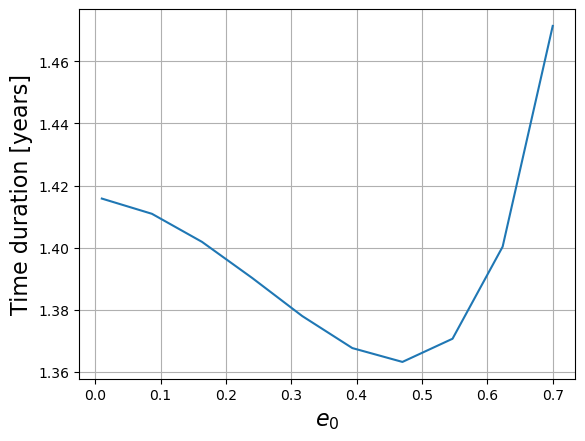

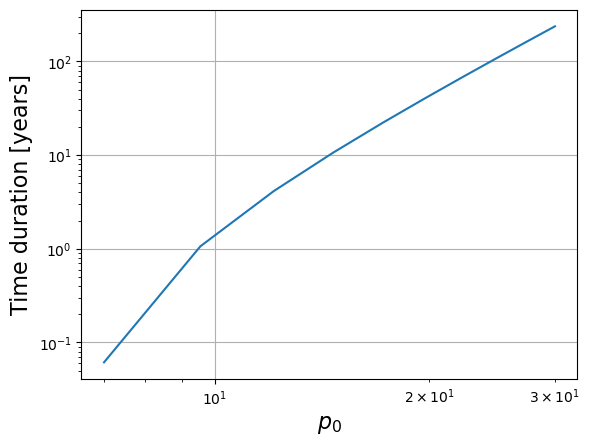

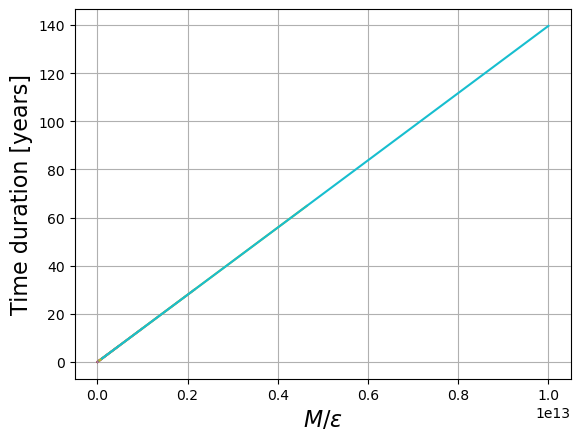

In [11]:
## # set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0


# Fix time duration to a very large number (100 years) so that we obtain the time duration from trajectory
kwargs = dict(dt=10.0, # initial time setp,
              T=1000.0,
              err=1e-10 # integrator error
             )

ecc = np.linspace(0.01, 0.7, num=10)

tfinal = []
for e0 in ecc:

    # get secondary mass for fixed mass ratio
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                                  Phi_phi0=0.0,
                                                  Phi_theta0=0.0,
                                                  Phi_r0=0.0,
                                                  **kwargs)

    tfinal.append(t[-1]/YRSID_SI)


plt.figure()
plt.plot(ecc, tfinal)
plt.ylabel('Time duration [years]', fontsize = 16)
plt.xlabel(r'$e_{0}$', fontsize = 16)
plt.grid()
plt.show()
############################
tfinal = []
e0 = 0.0 # reset eccentricity
pp = np.linspace(7.0, 30.0, num=10)
for p0 in pp:

    # get secondary mass for fixed mass ratio
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                                  Phi_phi0=0.0,
                                                  Phi_theta0=0.0,
                                                  Phi_r0=0.0,
                                                  **kwargs)

    tfinal.append(t[-1]/YRSID_SI)


plt.figure()
plt.loglog(pp, tfinal)
plt.ylabel('Time duration [years]', fontsize = 16)
plt.xlabel(r'$p_{0}$', fontsize = 16)
plt.grid()
plt.show()

############################
tfinal = []
e0 = 0.2 # reset
p0=10.0
mass_ratio_vector = 10**np.linspace(-4.0, -6.0, num=10)
Mvec = 10**np.linspace(4.0, 7.0, num=10)

plt.figure()
for M in Mvec:
    tfinal = []
    for epsilon in mass_ratio_vector:

        # get secondary mass for fixed mass ratio
        mu = M * epsilon
        t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                                      Phi_phi0=0.0,
                                                      Phi_theta0=0.0,
                                                      Phi_r0=0.0,
                                                      **kwargs)

        # inspiral duration (divide by YRSID_SI to get it in years)
        tfinal.append(t[-1]/YRSID_SI)

    plt.plot(M/mass_ratio_vector, tfinal)
plt.ylabel('Time duration [years]', fontsize = 16)
plt.xlabel(r'$M/\epsilon$', fontsize = 16)
plt.grid()
plt.show()




## Exercise 2

Plot the FINAL number of cycles (`Ncycle.append(Phi_phi[-1]/(2*np.pi))`) for different mass ratios.

In [ ]:
# set initial parameters
M = 1e6
mu = 1e1

# run trajectory
# must include for generic inputs, will fix a = 0 and x = 1.0
a = 0.0
x = 1.0
p0 = 10.0 # range [separatrix, 45]
e0 = 0.3 # range [0.0, 0.7]

Ncycle = []
for epsilon in mass_ratio_vector:

    # get secondary mass for fixed mass ratio
    mu = M * epsilon
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj(M, mu, a, p0, e0, x,
                                                  Phi_phi0=0.0,
                                                  Phi_theta0=0.0,
                                                  Phi_r0=0.0,
                                                  **kwargs)

    Ncycle.append(Phi_phi[-1]/(2*np.pi))


plt.figure()
plt.loglog(mass_ratio_vector, Ncycle)
plt.ylabel('Number of cycles')
plt.xlabel('Mass ratio')
plt.grid()
plt.show()

## Exercise 3

In [ ]:
# parameters
M = 1e6
mu = 1e1
p0 = 10.63
e0 = 0.3
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

plt.figure()
for dd in np.linspace(1.0,5.0,num=10):
    wave = few_gen(M, mu, p0, e0, theta, phi, dist=dd, dt=dt, T = 2)
    SNR = np.sqrt(inner_product(wave.real,wave.real,dt)+inner_product(wave.imag,wave.imag,dt))
    plt.plot(1/dd, SNR,'k.')
plt.xlabel(r'$1/d_{L}$',fontsize = 16)
plt.ylabel(r'$\rho$', fontsize = 16)
plt.grid()
plt.show()


plt.figure()
for mu in np.linspace(1.0,100.0,num=10):
    wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T= 0.05)
    SNR = np.sqrt(inner_product(wave.real,wave.real,dt)+inner_product(wave.imag,wave.imag,dt))
    plt.plot(mu, SNR,'k.')
plt.xlabel(r'$\mu$', fontsize = 16)
plt.ylabel(r'$\rho$', fontsize = 16)
plt.grid()
plt.show()

## Exercise 4

In [ ]:
# parameters
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0
T = 0.01

cmap = matplotlib.cm.get_cmap('inferno')
fig, axs = plt.subplots(1, 1)
axs.set_xlabel('$\log_{10}\delta e$')
axs.set_ylabel('Overlap')
vec = 10**np.linspace(-6, -2,num=10)
logd = np.log10(vec)

T=0.01
base_sig = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=T)
# M
O=[]
for delta in vec:
    wave = few_gen(M*(1+delta), mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=T)
    O.append(overlap(base_sig.real,wave.real,dt))

axs.scatter(logd, O , label=f'M')

# mu
O=[]
for delta in vec:
    wave = few_gen(M, mu*(1+delta), p0, e0, theta, phi, dist=1.0, dt=dt, T=T)
    O.append(overlap(base_sig.real,wave.real,dt))

axs.scatter(logd, O , label=f'mu')

# p0
O=[]
for delta in vec:
    wave = few_gen(M, mu, p0*(1+delta), e0, theta, phi, dist=1.0, dt=dt, T=T)
    O.append(overlap(base_sig.real,wave.real,dt))

axs.scatter(logd, O , label=f'p0')


plt.legend()
plt.grid()
plt.show()

## Exercise 5

Using the Fisher matrix formalism, try to understand how well we can measure the primary mass $M$ for the EMRI given above.

Using the Fisher matrix, prove that the fisher information on the distance can be written as

$$
\Gamma_{d_{L}d_{L}} = \frac{\rho^{2}}{d_{L}^{2}}
$$

where $\rho^{2} = (h|h)$ is the optimal matched-filtering SNR. Then verify that, indeed, we can measure $\Delta d_{L} = d_{L}/\rho$

In [ ]:
# Code

dM = 1e-1  # Set step size for numerical derivative

wave_p = few_gen(M + dM, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=2)
wave_m = few_gen(M - dM, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=2)

deriv_wave = (wave_p - wave_m)/(2*dM)

deriv_wave_fft = xp.fft.rfft(deriv_wave)

gamma_MM = inner_product(deriv_wave.real,deriv_wave.real,dt)  # Just a scalar

precision_M = gamma_MM**(-1/2)

print("Precision we can expect to measure the primary mass is", precision_M)


# Analytical solution

We need to calculate 

$$\Gamma_{d_{L}d_{L}} = 4\mathcal{R}\int_{0}^{\infty} \frac{1}{S_{n}(f)}\rvert \partial_{d_{L}}\tilde{h}\rvert^{2} df.$$

Notice that since $\tilde{h}(f) \sim 1/d_{L}$, we have that $\partial_{d_{L}}\tilde{h}(f) \sim -\frac{1}{d_{L}^2}$. We thus have that
$$ \partial_{d_{L}}\tilde{h}(f) = -\frac{1}{d_{L}}\tilde{h}(f) \Longrightarrow |\partial_{d_{L}}\tilde{h}(f)|^2 = \left(\frac{1}{d_{L}}\right)^2 |\tilde{h}(f)|^2 $$ This implies that
$$ \Gamma_{d_{L}d_{L}} = 4\mathcal{R}\int_{0}^{\infty} \frac{1}{S_{n}(f)}\big\rvert \partial_{d_{L}}\tilde{h}\big\rvert^{2} df = \left(\frac{1}{d_{L}}\right)^2 \cdot 4\mathcal{R}\int_{0}^{\infty} \frac{1}{S_{n}(f)}\big\rvert \tilde{h}(f)\big\rvert^{2} df = \left(\frac{(h|h)}{d_{L}}\right)^2 = \frac{\rho^2}{d_{L}^2}$$

The result then follows that $\Delta d_{L} = (\Gamma^{-1}_{d_{L}d_{L}})^{1/2} = \frac{d_{L}}{\rho} $ as required.

# Exercise 6

In the previous plot the different harmonics of the waveform can be recognized as tracks in time-frequency space. As exercise, try to plot the frequency tracks as a function of time on top of the previous plot. Take the same input parameters and run a trajectory to obtain the `p` and `e` evolution. Then pass these arrays into the the function `get_fundamental_frequencies` and obtain the three fundamental frequencies. Then convert to the correct units and plot the frequency $f=(m \Omega_\varphi + n \Omega_r)/(2\pi)$ for some values of your choice for $m$ and $n$.

In [ ]:
M = 1e6
mu = 1e2
p0 = 12.0
e0 = 0.0
theta = np.pi/3  # polar viewing angle in source frame
phi = np.pi/4  # azimuthal viewing angle in source frame
dt = 10.0

wave = few_gen(M, mu, p0, e0, theta, phi, dist=1.0, dt=dt, T=1.0)
f, t, Zxx = signal.stft(wave.real, 1/dt, nperseg=5000)

time, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, mu, 0.0, p0, e0, 1.0, T=1.0, dt=dt)
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(0.0, p, e, 1.0)
fharmonic = 2*OmegaPhi / (M*MTSUN_SI) / (np.pi*2)

plt.figure(figsize=(16,10))
cb = plt.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
plt.plot(time, fharmonic,'r')
plt.colorbar(cb,)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim([1e-4, f[-1]])

plt.show()

## Exercise 7

Now using the overlap function defined by

$$ \mathcal{O}(a,b) = \frac{(a|b)}{\sqrt{(a|a)(b|b)}}, \ \ \text{with inner product:} \ \ (a|b) = 4\int_{0}^{\infty}\frac{\tilde{a}(f)\tilde{b}^{\star}(f)}{S_{n}(f)}$$

try and show that the two waveform models `fd_gen` and `td_gen` are near equivalent for the parameters given above.

In [ ]:

ab = inner_product_FD(hp_fd[N_t//2 + 1:], hp_fft[1:], df, PSD_cp)
aa = inner_product_FD(hp_fd[N_t//2 + 1:], hp_fd[N_t//2 + 1:], df, PSD_cp)
bb = inner_product_FD(dt * hp_fft[1:], dt * hp_fft[1:], df, PSD_cp)

overlap = ab/np.sqrt(aa*bb)

print("Overlap between two models is = ", overlap)